In [206]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [207]:
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [208]:
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [209]:
df.shape

(253680, 22)

In [210]:
#check for NA values
df.isnull().values.any()

False

In [211]:
df.HeartDiseaseorAttack.value_counts()

0.0    229787
1.0     23893
Name: HeartDiseaseorAttack, dtype: int64

# Feature Engineering

Detailed descriptions of fields can be found in the CDC's codebook for the data here: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

In [212]:
#create dummy variable to indicate whether someone has a college degree
df['college_grad']= (df['Education'] == 6 ).astype(int)

#create variable to indicate whether someone makes more than $50,000 annually
df['high_income']= (df['Income'].isin([8,9]).astype(int))

#create variable to indicate whether people reported having poor mental health in more than 15 of the past 30 days
few_days = []
few_days.extend(range(1,15))
few_days.append(88)
df['good_mental_health']= (df['MentHlth'].isin(few_days).astype(int)) #88 is "None"

#create variable to indicate whether people report health as good/very good/excellent (1) vs fair/poor (0)
df['good_general_health']= (df['GenHlth'].isin([1,2,3]).astype(int)) 

df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,PhysHlth,DiffWalk,Sex,Age,Education,Income,college_grad,high_income,good_mental_health,good_general_health
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,15.0,1.0,0.0,9.0,4.0,3.0,0,0,0,0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,7.0,6.0,1.0,1,0,0,1
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,30.0,1.0,0.0,9.0,4.0,8.0,0,1,0,0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,11.0,3.0,6.0,0,0,0,1
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,11.0,5.0,4.0,0,0,1,1


In [213]:
df.drop(columns = ['MentHlth','GenHlth','PhysHlth','Education','Income'], inplace=True)

In [214]:
df.Diabetes.value_counts()

0.0    213703
2.0     35346
1.0      4631
Name: Diabetes, dtype: int64

Value of 2 for the Diabetes field is "Yes, but female told only during pregnancy" so I'll count it as Yes for diabetes.

In [215]:
df.Diabetes.replace(2,1, inplace=True)
df.Diabetes.value_counts()

0.0    213703
1.0     39977
Name: Diabetes, dtype: int64

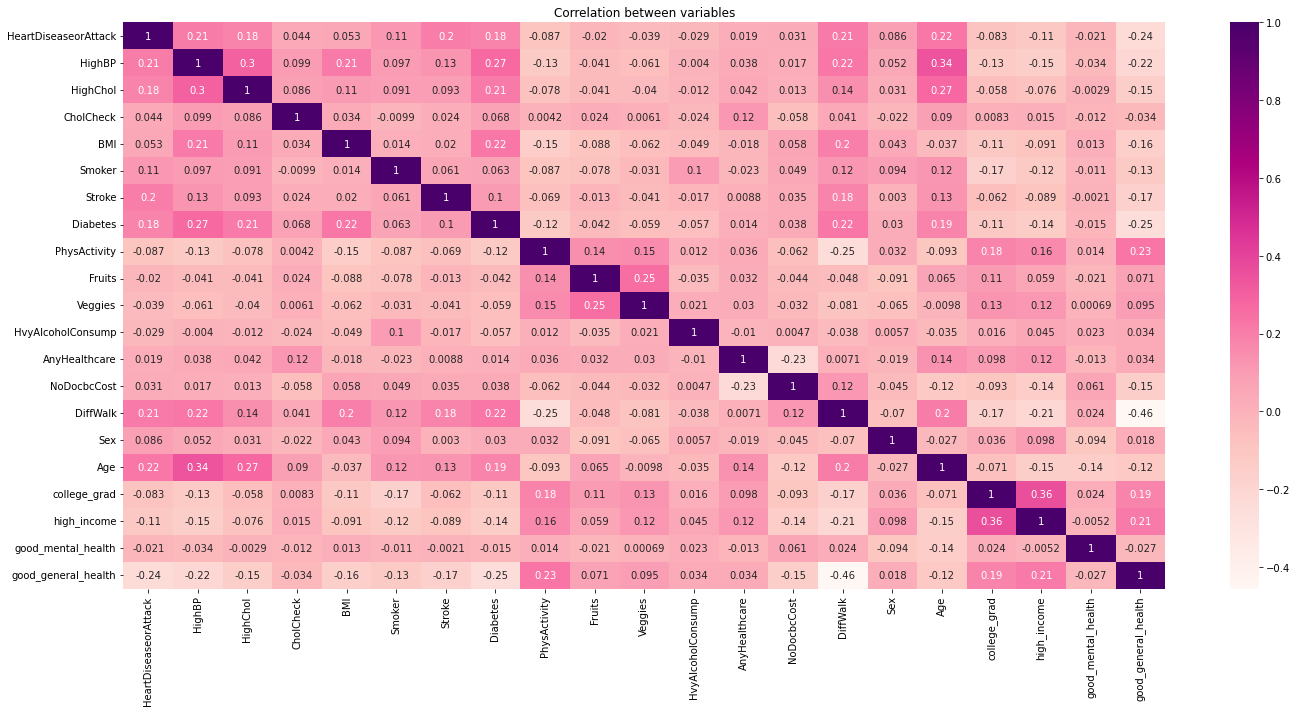

In [216]:
plt.subplots(figsize=(20,10))
feature_corr=df.corr()
sns.heatmap(feature_corr,annot=True,cmap='RdPu')
plt.title('Correlation between variables')
plt.xticks(rotation=90)
plt.tight_layout();

# Split and scale data

In [217]:
#drop several variables that show high correlation in the table above
X = df.drop(['HeartDiseaseorAttack'], axis=1)
y = df.HeartDiseaseorAttack

In [246]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   stratify = y,
                                                   random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Quick detour to check VIF to see if there is problematic multicollinearity for logistic regression.

In [219]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,vif
0,HighBP,2.302320
1,HighChol,2.033872
2,CholCheck,21.481795
3,BMI,16.239262
4,Smoker,1.933629
5,Stroke,1.104151
6,Diabetes,1.416915
7,PhysActivity,4.581396
8,Fruits,3.022398
9,Veggies,5.701816


# Test several baseline models

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False)
neigh = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5)

models = [lr, rf, xgb, neigh]

model_scores = {'Model':['Logistic Regression','Random Forest','XGB','KNN'],
               'Neg Log Loss':[],'Precision':[],'Recall':[]}

for model in models:
    scores = cross_validate(
        model, X_train, y_train, cv=cv, 
        scoring = ('neg_log_loss','precision','recall'),
        return_train_score=True)
    model_scores['Neg Log Loss'].append(scores['test_neg_log_loss'])
    model_scores['Precision'].append(scores['test_precision'])
    model_scores['Recall'].append(scores['test_recall']) 

In [120]:
model_scores_df = pd.DataFrame.from_dict(model_scores)
model_scores_df[['Neg Log Loss','Precision','Recall']] = model_scores_df[['Neg Log Loss','Precision','Recall']].apply(
    lambda x: np.mean(x))
model_scores_df

,Model,Neg Log Loss,Precision,Recall
0,Logistic Regression,-0.573144,0.439604,0.135823
1,Random Forest,-0.585770,0.430109,0.130722
2,XGB,-0.580914,0.450486,0.137719
3,KNN,-0.566398,0.449111,0.136477


In [121]:
import joblib
joblib.dump(model_scores, 'baseline_model_scores.pkl')

['baseline_model_scores.pkl']

Let's move forward with trying to improve the XGB model.

## Get a baseline score for the XGB classifier

In [17]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

#Estimate value to use for scale_pos_weight to account for imbalanced dataset
scale_pos_weight = y_train[y_train==0].count() / y_train[y_train==1].count()

xgb1 = XGBClassifier(booster='gbtree',
                     use_label_encoder = False,
                     learning_rate =0.1,
                     n_estimators=100,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     scale_pos_weight=scale_pos_weight,
                     n_jobs = -1,
                     verbosity=0)

cv = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

xgb1_scores = cross_validate(
    xgb1, X_train, y_train, cv=cv, 
    scoring = ('neg_log_loss','precision','recall'),
    return_train_score=True)

In [92]:
print(f"Test precision: {xgb1_scores['test_precision']}")
print(f"Mean test precision: {np.mean(xgb1_scores['test_precision'])}")
print(f"Test recall: {xgb1_scores['test_recall']}")
print(f"Mean test recall: {np.mean(xgb1_scores['test_recall'])}")
print(f"Test neg log loss: {xgb1_scores['test_neg_log_loss']}")
print(f"Mean test neg log loss: {np.mean(xgb1_scores['test_neg_log_loss'])}\n")

Test precision: [0.23785504 0.23919552 0.23186871 0.23830532 0.23456025]
Mean test precision: 0.2363569663700278
Test recall: [0.80172639 0.8150667  0.80198797 0.81951347 0.79199372]
Mean test recall: 0.8060576507308692
Test neg log loss: [-0.4874831  -0.48890105 -0.49724812 -0.48816938 -0.49013181]
Mean test neg log loss: -0.4903866945510643



In [93]:
print(f'Initial estimate for scale_pos_weight for the baseline model is {scale_pos_weight}')

Initial estimate for scale_pos_weight for the baseline model is 9.617557811028565


## Tune max_depth and min_child_weight

In [224]:
warnings.filterwarnings('ignore')

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

cv = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

grid_search1 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      gamma=0,
                                                      subsample=0.8,
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1,
                                                      verbosity=0), 
                            param_grid=param_test1, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

X_val=X_train
y_val=y_train

fit_params={"early_stopping_rounds" : 20, 
            "eval_metric" : "logloss", 
            "eval_set" : [[X_val, y_val]],
            "verbose" : False}

grid_search1.fit(X_train, y_train, **fit_params)

grid_search1.cv_results_, grid_search1.best_params_, grid_search1.best_score_
print(f"Best: {grid_search1.best_score_} using {grid_search1.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

Best: -0.455299047244943 using {'max_depth': 9, 'min_child_weight': 1}


In [97]:
joblib.dump(grid_search1, 'grid_search1.pkl')

['grid_search1.pkl']

Use min_child_weight of 1 going forward, but do another grid search to fine tune max_depth.

In [100]:
param_test2 = {
 'max_depth': range(9,22,3)
}

grid_search2 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      min_child_weight = 1,
                                                      gamma=0,
                                                      subsample=0.8,
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1,
                                                      verbosity=0), 
                            param_grid=param_test2, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

grid_search2.fit(X_train, y_train, **fit_params)

grid_search2.cv_results_, grid_search2.best_params_, grid_search2.best_score_
print(f"Best: {grid_search2.best_score_} using {grid_search2.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

({'mean_fit_time': array([ 97.86584792, 138.93481526, 170.64236403, 222.60184669,
         223.00968466]),
  'std_fit_time': array([ 0.52477529,  4.86231861,  0.76401579,  6.44198678, 46.81846669]),
  'mean_score_time': array([0.06287761, 0.08201299, 0.12150617, 0.1702384 , 0.2077714 ]),
  'std_score_time': array([0.00766332, 0.00417136, 0.01062969, 0.00907113, 0.03572617]),
  'param_max_depth': masked_array(data=[9, 12, 15, 18, 21],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 9},
   {'max_depth': 12},
   {'max_depth': 15},
   {'max_depth': 18},
   {'max_depth': 21}],
  'split0_test_score': array([-0.45314974, -0.40037042, -0.36196198, -0.35247386, -0.35143424]),
  'split1_test_score': array([-0.45257451, -0.39942445, -0.36107174, -0.35026248, -0.34909779]),
  'split2_test_score': array([-0.46284556, -0.41250414, -0.37405888, -0.36536545, -0.36580607]),
  'split3_test_score': array([-0.4533996

In [99]:
joblib.dump(grid_search2, 'grid_search2.pkl')

['grid_search2.pkl']

The improvement from max_depth of 18 to 21 was limited, so we will set max_depth of 18 going forward.

## Tune gamma

In [104]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

grid_search3 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      max_depth=18,
                                                      min_child_weight=1,
                                                      subsample=0.8,
                                                      colsample_bytree=0.8,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1), 
                            param_grid=param_test3, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

grid_search3.fit(X_train, y_train, **fit_params)

grid_search3.cv_results_, grid_search3.best_params_, grid_search3.best_score_
print(f"Best: {grid_search3.best_score_} using {grid_search3.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

[19:33:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:33:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:33:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:33:08] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:38:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[19:38:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:38:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:38:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:38:07] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarn

[19:44:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[19:49:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:39] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:54:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

({'mean_fit_time': array([297.6938705 , 326.14052606, 368.24932141, 586.08680215,
         531.03524218]),
  'std_fit_time': array([  1.94588635,  33.32573205,   0.56749862, 110.1911723 ,
         230.90827114]),
  'mean_score_time': array([0.29730287, 0.25755053, 0.23308482, 0.38379378, 0.44881845]),
  'std_score_time': array([0.07265768, 0.05200388, 0.06883079, 0.14647972, 0.26363372]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([-0.35247386, -0.35091547, -0.35139693, -0.35237769, -0.35242699]),
  'split1_test_score': array([-0.35026248, -0.35032659, -0.34932687, -0.35044378, -0.35024493]),
  'split2_test_score': array([-0.36536545, -0.36569256, -0.36553416, -0.36675921, -0.36665769]),
  'split3_test_score': array([-0.35316

In [105]:
joblib.dump(grid_search3, 'grid_search3.pkl')

['grid_search3.pkl']

Use gamma of 0.2 going forward.

## Tune subsample and colsample_bytree

In [106]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

grid_search4 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      max_depth=18,
                                                      min_child_weight=1,
                                                      gamma=0.2,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1), 
                            param_grid=param_test4, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

grid_search4.fit(X_train, y_train, **fit_params)

grid_search4.cv_results_, grid_search4.best_params_, grid_search4.best_score_
print(f"Best: {grid_search4.best_score_} using {grid_search4.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

[20:01:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:01:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:01:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:01:23] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:05:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:05:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:50] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:09:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:09:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:44] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:13:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:13:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:13:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:13:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:14:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:14:22] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:17:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:18:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:18:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:19:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:19:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:19:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:22:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:23:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:23:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:23:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:23:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:23:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:23:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:27:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:28:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:28:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:28:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:29:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:29:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:29:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:33:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:33:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:33:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:34:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:34:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:34:45] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:38:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:39:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:39:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:39:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:40:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:40:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:40:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:40:28] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:44:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:44:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:44:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:44:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[20:45:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:45:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:45:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:00] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

Best: -0.3539781983896261 using {'colsample_bytree': 0.8, 'subsample': 0.6}


In [107]:
joblib.dump(grid_search4, 'grid_search4.pkl')

['grid_search4.pkl']

Use colsample_bytree value of 0.8 and subsample value of 0.6 for final model.

## Tune regularization

In [109]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

grid_search5 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,
                                                      learning_rate =0.1,
                                                      n_estimators=100,
                                                      max_depth=18,
                                                      min_child_weight=1,
                                                      gamma=0.2,
                                                      colsample_bytree=0.8,
                                                      subsample=0.6,
                                                      objective= 'binary:logistic',
                                                      scale_pos_weight=scale_pos_weight,
                                                      n_jobs = -1), 
                            param_grid=param_test5, 
                            n_jobs = -1, 
                            cv=cv, 
                            scoring='neg_log_loss')

grid_search5.fit(X_train, y_train, **fit_params)

grid_search5.cv_results_, grid_search5.best_params_, grid_search5.best_score_
print(f"Best: {grid_search5.best_score_} using {grid_search5.best_params_}")

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

[21:15:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:15:26] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[21:19:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:19:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:19:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:19:40] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

[21:23:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:59] WARNING: /Users/runner/miniforge3/cond

/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Ind

[21:24:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:24:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:25:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1644955448402/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/ngoodby/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/dat

Best: -0.35400179842633517 using {'reg_alpha': 0.1}


In [110]:
joblib.dump(grid_search5, 'grid_search5.pkl')

['grid_search5.pkl']

Use reg_alpha of 0.1.

## Score model with current chosen hyperparameters and compare to the baseline model

In [15]:
warnings.filterwarnings('ignore')

xgb2 = XGBClassifier(use_label_encoder = False,
                          learning_rate=0.1,
                          n_estimators=500,
                          max_depth=18,
                          min_child_weight=1,
                          gamma=0.2,
                          colsample_bytree=0.8,
                          reg_alpha=0.1,
                          subsample=0.6,
                          objective= 'binary:logistic',
                          scale_pos_weight=scale_pos_weight,
                          n_jobs = -1,
                          verbosity=0)

cv = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

xgb2_scores = cross_validate(
    xgb2, X_train, y_train, cv=cv, 
    scoring = ('neg_log_loss','precision','recall'),
    return_train_score=True)

In [16]:
print(f"Test precision: {xgb2_scores['test_precision']}")
print(f"Mean test precision: {np.mean(xgb2_scores['test_precision'])}")
print(f"Test recall: {xgb2_scores['test_recall']}")
print(f"Mean test recall: {np.mean(xgb2_scores['test_recall'])}")
print(f"Test neg log loss: {xgb2_scores['test_neg_log_loss']}")
print(f"Mean test neg log loss: {np.mean(xgb2_scores['test_neg_log_loss'])}\n")

Test precision: [0.2573499  0.26300149 0.24980346 0.25885276 0.25495868]
Mean test precision: 0.256793256743481
Test recall: [0.32513733 0.32409103 0.33246142 0.32696835 0.32286761]
Mean test recall: 0.326305146095139
Test neg log loss: [-0.43422544 -0.43354464 -0.45353291 -0.43817425 -0.44576233]
Mean test neg log loss: -0.4410479144855259



In [18]:
model_score_compare = {'Model':['XGB Baseline','XGB Tuned'],
                      'Mean Precision':[np.mean(xgb1_scores['test_precision']), np.mean(xgb1_scores['test_precision'])],
                      'Mean Recall':[np.mean(xgb1_scores['test_recall']), np.mean(xgb2_scores['test_recall'])],
                      'Mean Negative Log Loss':[np.mean(xgb1_scores['test_neg_log_loss']),np.mean(xgb2_scores['test_neg_log_loss'])]
                      }
model_compare_df = pd.DataFrame.from_dict(model_score_compare)
model_compare_df

,Model,Mean Precision,Mean Recall,Mean Negative Log Loss
0,XGB Baseline,0.236357,0.806058,-0.490387
1,XGB Tuned,0.236357,0.326305,-0.441048


Let's compare that score to what happens if we reduce the learning rate and boost the number of trees.

In [19]:
warnings.filterwarnings('ignore')

xgb_final = XGBClassifier(use_label_encoder = False,
                          learning_rate=0.01,
                          n_estimators=500,
                          max_depth=18,
                          min_child_weight=1,
                          gamma=0.2,
                          colsample_bytree=0.8,
                          reg_alpha=0.1,
                          subsample=0.6,
                          objective= 'binary:logistic',
                          scale_pos_weight=scale_pos_weight,
                          n_jobs = -1,
                          verbosity=0)

cv = StratifiedKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)

xgb_final_scores = cross_validate(
    xgb_final, X_train, y_train, cv=cv, 
    scoring = ('neg_log_loss','precision','recall'),
    return_train_score=True)

In [20]:
model_score_compare = {'Model':['XGB Baseline','XGB Tuned','XGB Final'],
                      'Mean Precision':[np.mean(xgb1_scores['test_precision']), np.mean(xgb1_scores['test_precision']),np.mean(xgb_final_scores['test_precision'])],
                      'Mean Recall':[np.mean(xgb1_scores['test_recall']), np.mean(xgb2_scores['test_recall']), np.mean(xgb_final_scores['test_recall'])],
                      'Mean Negative Log Loss':[np.mean(xgb1_scores['test_neg_log_loss']),np.mean(xgb2_scores['test_neg_log_loss']), np.mean(xgb_final_scores['test_neg_log_loss'])]
                      }
model_compare_df = pd.DataFrame.from_dict(model_score_compare)
model_compare_df

,Model,Mean Precision,Mean Recall,Mean Negative Log Loss
0,XGB Baseline,0.236357,0.806058,-0.490387
1,XGB Tuned,0.236357,0.326305,-0.441048
2,XGB Final,0.283340,0.514230,-0.351004


In [29]:
joblib.dump(model_compare_df, 'model_compare_df.pkl')

['model_compare_df.pkl']

That improved scores nicely. Let's fit the xgb_final model on the training data and move on to looking at potentially adjusting the threshold.

In [26]:
xgb_final.fit(X_train, y_train, **fit_params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
              scale_pos_weight=9.617557811028565, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [ ]:
joblib.dump(xgb_final, 'xgb_final.pkl')

## Explore threshold adjustments

Split training data into training and validation data to do some predictions and look at PR curve and ROC curve.

In [247]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=42)
X_val = scaler.transform(X_val)

In [132]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

def plot_pr_curve(y_actual, y_pred): 
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(
        y_actual, y_pred)
    fig=plt.figure(dpi=80)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above this probability, suspect heart disease)');
    plt.title('Precision and Recall Curves')
    plt.tight_layout
    return fig

def plot_roc_curve(y_actual, y_pred):
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    roc_auc = metrics.auc(fpr,tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='XGB')
    display.plot()
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.tight_layout()
    plt.show()

    
def print_confusion_matrix(y_actual, y_pred, threshold=0.5):
    y_pred_confusion = (y_pred >= threshold)
    confusion = confusion_matrix(y_actual, y_pred_confusion)
    plt.figure(dpi=100)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
               xticklabels=['No Heart Disease','Heart Disease'],
               yticklabels =['No Heart Disease','Heart Disease'],
               fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.yticks(rotation=0)
    plt.title('Confusion Martix')
    plt.show()

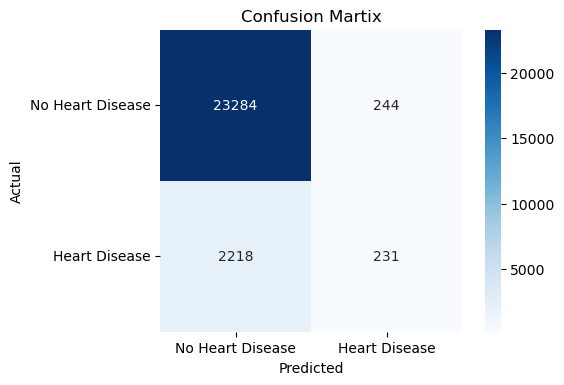

In [87]:
y_pred = xgb_final.predict(X_val)
print_confusion_matrix(y_val, y_pred)

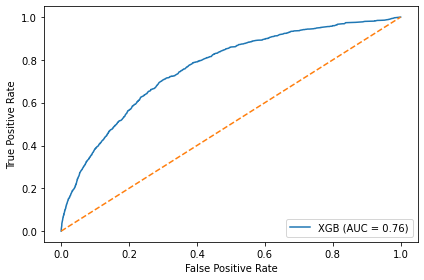

In [88]:
y_pred = xgb_final.predict_proba(X_val)[:,1]
plot_roc_curve(y_val, y_pred)

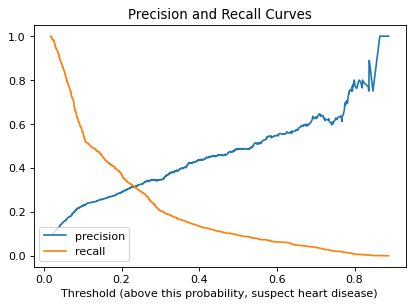

In [89]:
fig = plot_pr_curve(y_val, y_pred)

Let's tune the class weighting hyperparameter and see if we can reduce the number of false negatives.

scale_pos_weight: 8.5


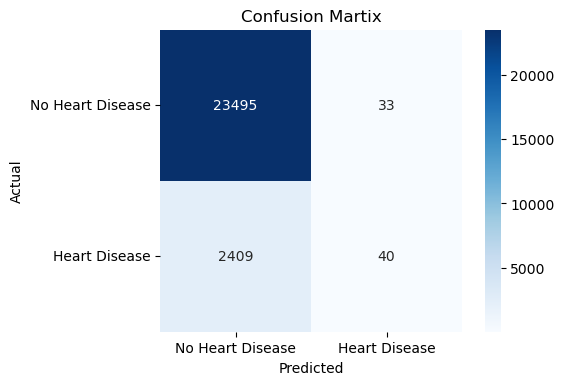

scale_pos_weight: 9


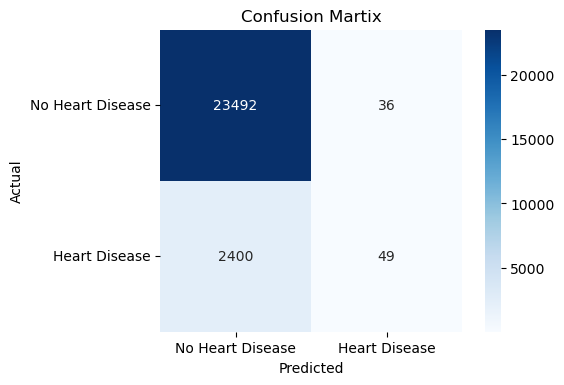

scale_pos_weight: 9.5


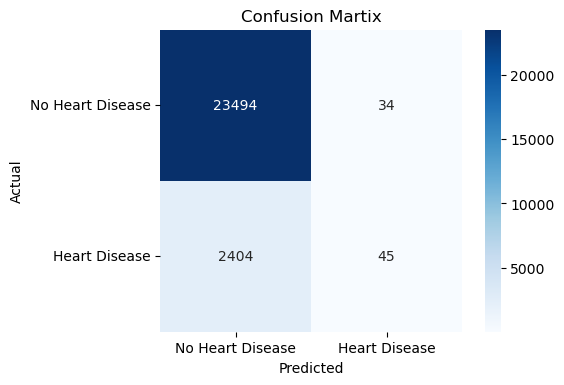

In [112]:
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score

weights = [8.5,9,9.5]
results={'scale_pos_weight':[],
        'Recall':[],
        'Precision':[]
        }

for i in weights:
    xgb_weight = XGBClassifier(scale_pos_weight=i,
                                  use_label_encoder = False,
                                  learning_rate=0.01,
                                  n_estimators=500,
                                  max_depth=18,
                                  min_child_weight=1,
                                  gamma=0.2,
                                  colsample_bytree=0.8,
                                  reg_alpha=0.1,
                                  subsample=0.6,
                                  objective= 'binary:logistic',
                                  n_jobs = -1,
                                  verbosity=0)
    xgb_weight.fit(X_train,y_train)
    y_pred = xgb_weight.predict(X_val)
    results['scale_pos_weight'].append(i)
    results['Recall'].append(recall_score(y_val,y_pred))
    results['Precision'].append(precision_score(y_val,y_pred))
    print(f'scale_pos_weight: {i}')
    print_confusion_matrix(y_val,y_pred)

Looks like a scale_pos_weight of 9 does a good job of minimizing false negatives. So we'll use that for our final model to predict the test data. 

# Predict test data and score model

In [205]:
xgb = XGBClassifier(scale_pos_weight=9,
                              use_label_encoder = False,
                              learning_rate=0.01,
                              n_estimators=500,
                              max_depth=18,
                              min_child_weight=1,
                              gamma=0.2,
                              colsample_bytree=0.8,
                              reg_alpha=0.1,
                              subsample=0.6,
                              objective= 'binary:logistic',
                              n_jobs = -1,
                              verbosity=0)

xgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=20,
            eval_metric='logloss',
            verbose=False) 

[0]	validation_0-logloss:0.68801	validation_1-logloss:0.68851
[1]	validation_0-logloss:0.68349	validation_1-logloss:0.68430
[2]	validation_0-logloss:0.67873	validation_1-logloss:0.67996
[3]	validation_0-logloss:0.67389	validation_1-logloss:0.67552
[4]	validation_0-logloss:0.66938	validation_1-logloss:0.67148
[5]	validation_0-logloss:0.66479	validation_1-logloss:0.66733
[6]	validation_0-logloss:0.66033	validation_1-logloss:0.66332
[7]	validation_0-logloss:0.65587	validation_1-logloss:0.65930
[8]	validation_0-logloss:0.65141	validation_1-logloss:0.65530
[9]	validation_0-logloss:0.64782	validation_1-logloss:0.65205
[10]	validation_0-logloss:0.64353	validation_1-logloss:0.64821
[11]	validation_0-logloss:0.64001	validation_1-logloss:0.64501
[12]	validation_0-logloss:0.63653	validation_1-logloss:0.64172
[13]	validation_0-logloss:0.63311	validation_1-logloss:0.63859
[14]	validation_0-logloss:0.62947	validation_1-logloss:0.63519
[15]	validation_0-logloss:0.62539	validation_1-logloss:0.63156
[1

[130]	validation_0-logloss:0.39286	validation_1-logloss:0.43490
[131]	validation_0-logloss:0.39180	validation_1-logloss:0.43410
[132]	validation_0-logloss:0.39035	validation_1-logloss:0.43306
[133]	validation_0-logloss:0.38943	validation_1-logloss:0.43235
[134]	validation_0-logloss:0.38827	validation_1-logloss:0.43149
[135]	validation_0-logloss:0.38706	validation_1-logloss:0.43061
[136]	validation_0-logloss:0.38617	validation_1-logloss:0.42995
[137]	validation_0-logloss:0.38544	validation_1-logloss:0.42937
[138]	validation_0-logloss:0.38420	validation_1-logloss:0.42848
[139]	validation_0-logloss:0.38301	validation_1-logloss:0.42762
[140]	validation_0-logloss:0.38186	validation_1-logloss:0.42680
[141]	validation_0-logloss:0.38064	validation_1-logloss:0.42595
[142]	validation_0-logloss:0.37992	validation_1-logloss:0.42542
[143]	validation_0-logloss:0.37890	validation_1-logloss:0.42467
[144]	validation_0-logloss:0.37783	validation_1-logloss:0.42388
[145]	validation_0-logloss:0.37690	valid

[259]	validation_0-logloss:0.30037	validation_1-logloss:0.37445
[260]	validation_0-logloss:0.29988	validation_1-logloss:0.37416
[261]	validation_0-logloss:0.29958	validation_1-logloss:0.37403
[262]	validation_0-logloss:0.29907	validation_1-logloss:0.37376
[263]	validation_0-logloss:0.29858	validation_1-logloss:0.37351
[264]	validation_0-logloss:0.29825	validation_1-logloss:0.37333
[265]	validation_0-logloss:0.29775	validation_1-logloss:0.37306
[266]	validation_0-logloss:0.29748	validation_1-logloss:0.37294
[267]	validation_0-logloss:0.29715	validation_1-logloss:0.37279
[268]	validation_0-logloss:0.29660	validation_1-logloss:0.37248
[269]	validation_0-logloss:0.29613	validation_1-logloss:0.37222
[270]	validation_0-logloss:0.29568	validation_1-logloss:0.37199
[271]	validation_0-logloss:0.29550	validation_1-logloss:0.37192
[272]	validation_0-logloss:0.29514	validation_1-logloss:0.37173
[273]	validation_0-logloss:0.29495	validation_1-logloss:0.37166
[274]	validation_0-logloss:0.29451	valid

[388]	validation_0-logloss:0.25971	validation_1-logloss:0.35666
[389]	validation_0-logloss:0.25941	validation_1-logloss:0.35653
[390]	validation_0-logloss:0.25919	validation_1-logloss:0.35646
[391]	validation_0-logloss:0.25885	validation_1-logloss:0.35633
[392]	validation_0-logloss:0.25871	validation_1-logloss:0.35630
[393]	validation_0-logloss:0.25859	validation_1-logloss:0.35628
[394]	validation_0-logloss:0.25834	validation_1-logloss:0.35620
[395]	validation_0-logloss:0.25803	validation_1-logloss:0.35608
[396]	validation_0-logloss:0.25783	validation_1-logloss:0.35600
[397]	validation_0-logloss:0.25784	validation_1-logloss:0.35607
[398]	validation_0-logloss:0.25772	validation_1-logloss:0.35607
[399]	validation_0-logloss:0.25754	validation_1-logloss:0.35603
[400]	validation_0-logloss:0.25726	validation_1-logloss:0.35594
[401]	validation_0-logloss:0.25686	validation_1-logloss:0.35576
[402]	validation_0-logloss:0.25645	validation_1-logloss:0.35557
[403]	validation_0-logloss:0.25630	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
              scale_pos_weight=9, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [245]:
xgb_more_trees = XGBClassifier(scale_pos_weight=9,
                              use_label_encoder = False,
                              learning_rate=0.01,
                              n_estimators=5000,
                              max_depth=18,
                              min_child_weight=1,
                              gamma=0.2,
                              colsample_bytree=0.8,
                              reg_alpha=0.1,
                              subsample=0.6,
                              objective= 'binary:logistic',
                              n_jobs = -1,
                              verbosity=0)

xgb_more_trees.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=20,
            eval_metric='logloss',
            verbose=False) 

xgb_more_trees.best_ntree_limit

3094

In [244]:
xgb.best_ntree_limit

500

In [241]:
joblib.dump(xgb, 'xgb.pkl')

['xgb.pkl']

In [248]:
xgb_best = XGBClassifier(scale_pos_weight=9,
                              use_label_encoder = False,
                              learning_rate=0.01,
                              n_estimators=3094,
                              max_depth=18,
                              min_child_weight=1,
                              gamma=0.2,
                              colsample_bytree=0.8,
                              reg_alpha=0.1,
                              subsample=0.6,
                              objective= 'binary:logistic',
                              n_jobs = -1,
                              verbosity=0)

xgb_best.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            early_stopping_rounds=20,
            eval_metric='logloss',
            verbose=False) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3094, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
              scale_pos_weight=9, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [249]:
joblib.dump(xgb_best, 'xgb_best.pkl')

['xgb_best.pkl']

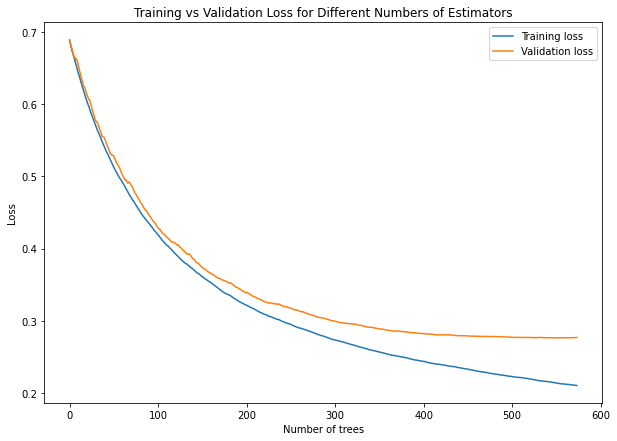

In [263]:
results = xgb_best.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
# plt.axvline(21, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.title('Training vs Validation Loss for Different Numbers of Estimators')
plt.legend();

In [252]:
#bring training and validation data back together for final model training
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

X_train = pd.concat([X_train,X_val])
y_train = pd.concat([y_train,y_val])

XGBoost Model best F1 score 0.363 at prob decision threshold >= 0.484


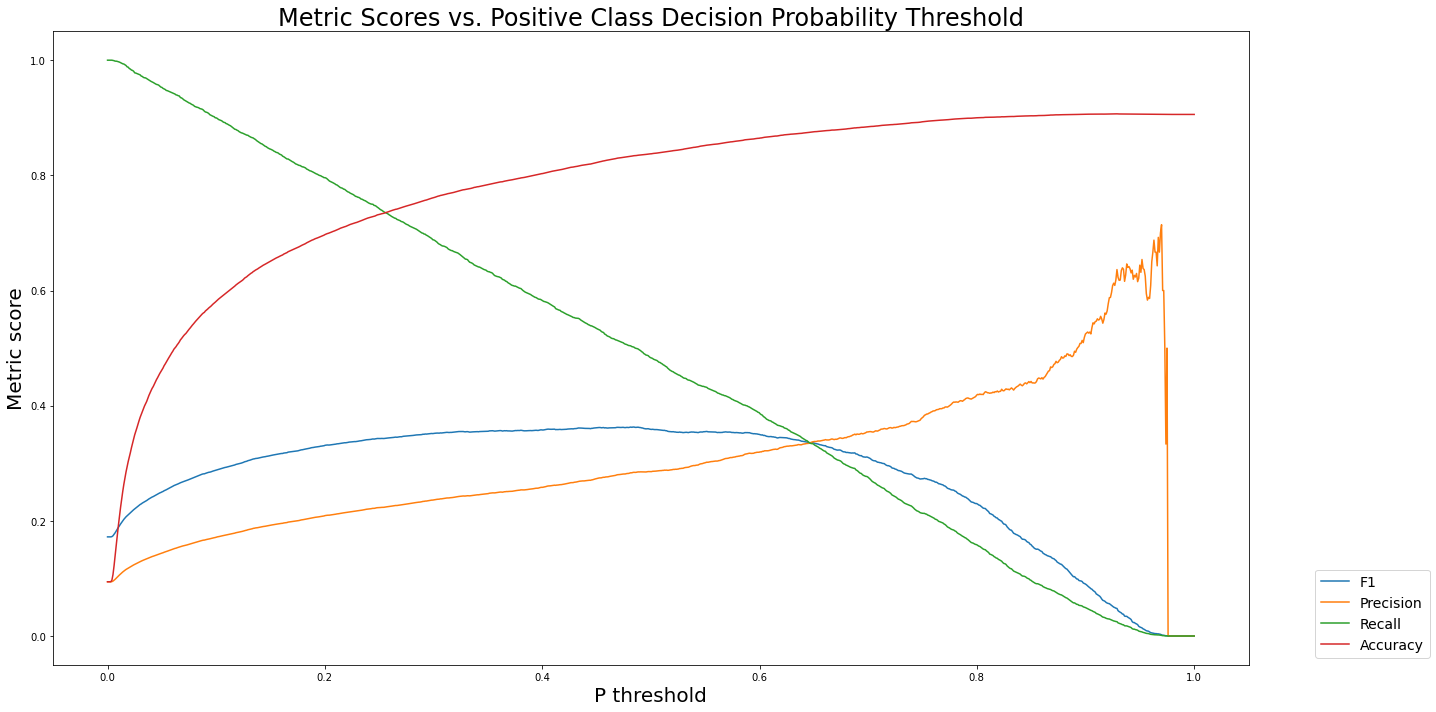

In [253]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

thresh_ps = np.linspace(0,1,1000)
model_val_probs = xgb_best.predict_proba(X_test)[:,1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    prec_scores.append(precision_score(y_test, model_val_labels))
    rec_scores.append(recall_score(y_test, model_val_labels))
    acc_scores.append(accuracy_score(y_test, model_val_labels))

plt.figure(figsize=(20,10))
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold', fontsize=24)
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left',fontsize=14)
plt.xlabel('P threshold', fontsize=20)
plt.ylabel('Metric score', fontsize=20)
plt.tight_layout()
plt.savefig('threshold_figure.png')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('XGBoost Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [254]:
y_pred = xgb_best.predict_proba(X_test)[:,1]

interactive(lambda threshold: print_confusion_matrix(y_test, y_pred, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

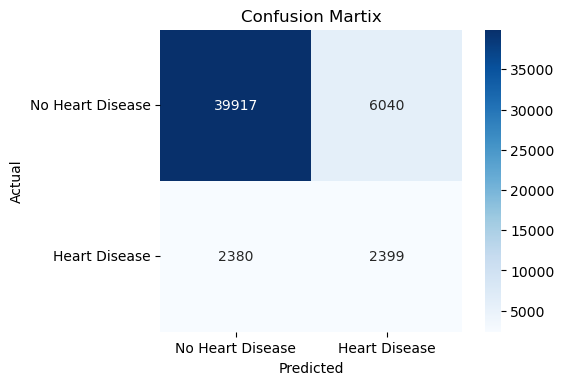

In [255]:
y_pred = np.where(y_pred>=0.484, 1, 0)
print_confusion_matrix(y_test, y_pred)

In [256]:
print(f"{round((2380/len(y_test))*100, 3)} percent of total predictions are false negatives")

4.691 percent of total predictions are false negatives


In [257]:
X.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'Diabetes', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'Age',
       'college_grad', 'high_income', 'good_mental_health',
       'good_general_health'],
      dtype='object')

In [258]:
xgb_best.get_booster().feature_names = ['High Blood Pressure', 'High Cholesterol', 'Chol Check', 'BMI', 
                                   'Smoker', 'Stroke', 'Diabetes', 'Physical Activity', 'Fruits', 'Veggies', 
                                   'Heavy Alcohol Consump','Any Healthcare', 'No Doc Because Cost', 
                                   'Difficulty Walking', 'Sex', 'Age', 'College Grad', 'High Income', 
                                   'Good Mental Health', 'Good General Health']

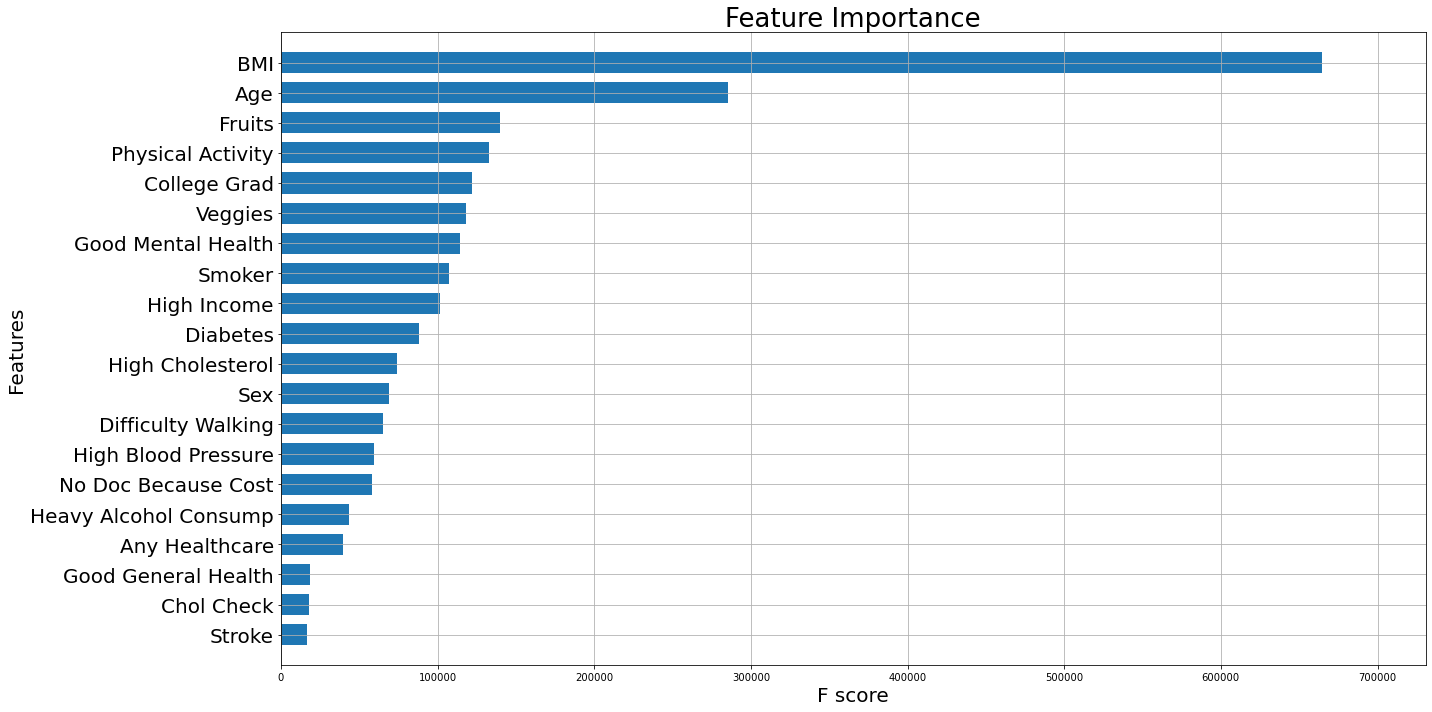

In [259]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(20, 10))
plt.yticks(fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.xlabel('F Score', fontsize=20)
plt.title('Feature Importance', fontsize=26)
plot_importance(booster=xgb_best, ax=ax, title=None, height=0.7, show_values=False)
plt.tight_layout()
plt.show()

In [261]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_pred))
print(recall_score(y_test,y_pred))

0.2842753880791563
0.5019878635697844
